In [1]:
import os
import importlib
import copy
from tqdm import tqdm

In [2]:
from nasbench import api  # NB101
from nas_201_api import NASBench201API as API  # NB201
import nasbench301 as nb  # NB301
import nats_bench  # NATS

2024-09-23 13:03:21.039194: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-23 13:03:21.123918: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-23 13:03:21.125036: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 13:03:27.654968: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# models_1_0_dir = "../api/nasbench301_models_v1.0/nb_models"
# model_paths = {
#     model_name: os.path.join(models_1_0_dir, '{}_v1.0'.format(model_name))
#     for model_name in ['xgb', 'lgb_runtime']
# }
# NB_301_performance_model = nb.load_ensemble(model_paths['xgb'])

# nas_bench_201_api = API('../api/NAS-Bench-201-v1_1-096897.pth', verbose=False)

# nas_bench_101_api = api.NASBench("../api/nasbench_full.tfrecord")

nats_bench_api = nats_bench.create("../api/NATS-sss-v1_0-50262-simple", "sss", fast_mode=True, verbose=False)

In [4]:
class MyNode:
    """
    Représente un noeud dans l'arbre de recherche.
    """

    def __init__(self, state, move=None, parent=None, sequence=[], zobrist_table=None):
        self.state = state
        self.move = move
        self.parent = parent
        self.children = []
        self.results = []
        self.amaf = []  # For RAVE and variants
        self.sequence = sequence  # For Nested MCS and variants
        self.hash = None
        if zobrist_table is not None:
            self.hash = self.calculate_zobrist_hash(zobrist_table)

    def get_children(self):
        return self.children

    def is_leaf(self):
        return True if len(self.children) == 0 else False

    def is_terminal(self):
        return self.state.is_complete()

    def get_action_tuples(self):
        return self.state.get_action_tuples()

    def calculate_zobrist_hash(self, zobrist_table):
        return self.state.calculate_zobrist_hash(zobrist_table)

    def add_zobrist(self, zobrist_table):
        ### Normalement cette fonction est seulement censée être utilisée pour la racine.
        if self.hash is None:  # Ne pas recalculer si on a déjà calculé
            self.hash = self.calculate_zobrist_hash(zobrist_table)

    def get_reward(self, api, df=None):
        return self.state.get_reward(api, df)

    def get_metric(self, metric, api, df=None):
        return self.state.get_metric(metric, api, df)

    def play_action(self, action):
        self.state.play_action(*action)

    def has_predecessor(self, node):
        """
        Return True if self is a child of node (can be several generations)
        :param node:
        :return:
        """
        temp_parent = self.parent
        while temp_parent.parent is not None:
            if temp_parent == node:
                return True
            temp_parent = temp_parent.parent
        if temp_parent == node:  # Include root (pas sûr)
            return True
        return False

In [5]:
# NAS-Bench-101
from nas_bench_101 import NASBench101Node
importlib.reload(NASBench101Node)
from nas_bench_101.NASBench101Node import *

# NAS-Bench-201
from nas_bench_201 import NASBench201Node
importlib.reload(NASBench201Node)
from nas_bench_201.NASBench201Node import *

# NAS-Bench-301
from nas_bench_301 import NASBench301Node
importlib.reload(NASBench301Node)
from nas_bench_301.NASBench301Node import *

# NATS-Bench
from nats_bench_dataset import NATSBenchNode
importlib.reload(NATSBenchNode)
from nats_bench_dataset.NATSBenchNode import *

In [6]:
# state_101 = NASBench101Cell(n_vertices=7)
# state_201 = NASBench201Cell(n_vertices=4)
# state_301 = DARTSState((DARTSCell(), DARTSCell()))
state_nats = NATSBenchSizeCell()

In [7]:
from search_algorithms.MCTS import mcts_agent
importlib.reload(mcts_agent)
from search_algorithms.MCTS.mcts_agent import *

from search_algorithms.MCTS import nested
importlib.reload(nested)
from search_algorithms.MCTS.nested import *

In [8]:
dic = {
       # "NASBench101": {"state": state_101, 
       #                 "api": nas_bench_101_api},
       # "NASBench201": {"state": state_201, 
       #                 "api": nas_bench_201_api}}
       # "NASBench301": {"state": state_301, 
       #                 "api": NB_301_performance_model},
       "NATSBench": {"state": state_nats, 
                       "api": nats_bench_api}}

In [9]:
for name, values in dic.items():
    print(name)
    rn = MyNode(state=copy.deepcopy(values["state"]))
    # rn.state.initialize_zobrist_table()
    mc = NRPA(root_node=rn, level=2, params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json", api=values["api"])
    mc.n_iter= 50
    node, _, _ = mc.main_loop()
    print(node.is_terminal())

NATSBench


Current best reward : 70.5400:   7%|▌        | 165/2500 [00:08<02:05, 18.64it/s]

KeyboardInterrupt: 

Current best reward : 70.5400:   7%|▌        | 165/2500 [00:19<02:05, 18.64it/s]

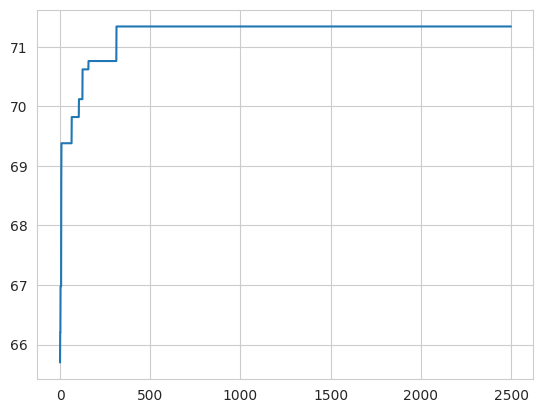

In [18]:
import matplotlib.pyplot as plt
plt.plot(mc.best_reward)

In [19]:
mc.best_reward[-1]

71.33999998779296

In [116]:
from search_algorithms.MCTS.nested import NestedMCS
class ParetoNRPA(NestedMCS):

    def __init__(self, root_node: NestedNode, level, api=None, params_path=None):
        super().__init__(root_node, level, api=api, params_path=params_path)
        self.policy = {}
        # self.n_iter = 100
        # self.alpha = .01  # Learning rate
        if self.root.state.zobrist_table is None: self.root.state.initialize_zobrist_table()
        self.pareto_front = []
        self.max_pareto_size = 10
        self.obj1_list = []
        self.obj2_list = []
        self.visited_nodes = []

    def read_params(self, path):
        super().read_params(path)
        with open(path, "r") as f:
            dic = json.load(f)
        self.n_iter = dic["mcts"]["nrpa_n_iter"]
        self.alpha = dic["mcts"]["nrpa_alpha"]
        self.softmax_temp = dic["mcts"]["softmax_temp"]

    def _code(self, node, move):

        if move == None:
            ### SEULEMENT POUR LA RACINE DE L'ARBRE A PRIORI
            return node.hash

        state_code = node.hash
        code = str(state_code) 
        # code = ""  # J'enlève le hashage de zobrist pour le moment # justepourvoir
        for i in range(len(move)):
            code = code + str(move[i])

        return code

    def adapt(self, list_sequences):
        node_type = type(self.root)
        node = node_type(state=copy.deepcopy(self.root.state), move=None, parent=None, sequence=[])

        node.hash = node.calculate_zobrist_hash(self.root.state.zobrist_table)
        pol_prime = self.policy.copy()
        for sequence in list_sequences:
            for action in sequence:
                code = self._code(node, action)
                if code not in pol_prime:
                    # print("Erreur 0")
                    pol_prime[code] = 0
                pol_prime[code] += self.alpha
                z = 0
                moves = node.get_action_tuples()
                for m in moves:
                    move_code = self._code(node, m)
                    # if move_code not in self.policy:
                    #     print("Erreur 1")
                    #     self.policy[move_code] = 0
                    z += np.exp(self.policy[move_code])
                for m in moves:
                    move_code = self._code(node, m)
                    # if move_code not in pol_prime:
                    #     print("Erreur 2")
                    #     pol_prime[move_code] = 0
                    pol_prime[move_code] -= self.alpha * (np.exp(self.policy[move_code]) / z)
        
                node.play_action(action)
                node.hash = node.calculate_zobrist_hash(self.root.state.zobrist_table)

        return pol_prime

    def _playout(self, node: NestedNode):
        node_type = type(node)
        playout_node = node_type(state=copy.deepcopy(node.state), move=copy.deepcopy(node.move),
                                 parent=copy.deepcopy(node.parent), sequence=copy.deepcopy(node.sequence))
        sequence = playout_node.sequence
        playout_node.hash = playout_node.calculate_zobrist_hash(self.root.state.zobrist_table)

        while not playout_node.is_terminal():

            # Vérifier si la policy a une valeur pour ce noeud
            if self._code(playout_node, playout_node.move) not in self.policy:
                self.policy[self._code(playout_node, playout_node.move)] = 0

            available_actions = playout_node.get_action_tuples()
            probabilities = []
            for move in available_actions:
                if self._code(playout_node, move) not in self.policy:
                    self.policy[self._code(playout_node, move)] = 0

            policy_values = [self.policy[self._code(playout_node, move)] for move in
                             available_actions]  # Calcule la probabilité de sélectionner chaque action avec la policy
                             
            probabilities = softmax_temp(np.array(policy_values), self.softmax_temp)
            # if len(self.best_reward) % 100 == 0:
            #     pprint(list(zip(available_actions, pplayout_node# Used because available_actions is not 1-dimensional
            action_index = np.random.choice(np.arange(len(available_actions)), p=probabilities)
            action = available_actions[action_index]  # Used because available_actions is not 1-dimensional
            
            sequence.append(action)
            playout_node.play_action(action)
            playout_node.hash = playout_node.calculate_zobrist_hash(self.root.state.zobrist_table)

        reward = playout_node.get_reward(self.api, self.df)
        n_params = playout_node.get_metric("n_params", self.api, self.df)
        playout_node.sequence = sequence
        return 1-reward, n_params, sequence, playout_node

    def nrpa(self, node, level):

        if level == 0:
            self.pbar.update(1)
            self.pbar.set_description(f"Current best reward : {self.best_reward_value:.4f}")
            # if (len(self.rewards)+1) % 1000 == 0:
            #     f, ax = plt.subplots(1,1)
            #     ax.plot(running_avg(self.rewards, 10))
            #     f.savefig("rewards.png")
            #     plt.close(f)
            #     f, ax = plt.subplots(1,1)
            #     ax.plot(running_avg(self.best_reward, 10))
            #     f.savefig("best_rewards.png")
            #     plt.close(f)
            #     node_type = type(self.root)
            #     playout_node = node_type(copy.deepcopy(self.root.state), sequence=[])
            #     playout_node.hash = playout_node.calculate_zobrist_hash(self.root.state.zobrist_table)

            #     act = playout_node.get_action_tuples()
            #     probas = softmax_temp(np.array([self.policy[self._code(playout_node, move)] for move in act]), self.softmax_temp)

            #     f, ax = plt.subplots(1,1)
            #     df = pd.DataFrame({"action": act, "probability": probas}).sort_values('probability', ascending=False)
            #     sns.barplot(df.iloc[:20], x="action", y="probability", color="#3d405b")
            #     plt.xticks(rotation=90)
            #     f.savefig("best_actions.png")
            #     plt.close(f)
            #     print(f"[{len(self.rewards)}/{self.n_iter ** self.level}] Best reward: {self.best_reward_value}")
            
            obj1, obj2, sequence, playout_node = self._playout(self.root)
            self.visited_nodes.append(playout_node)
            self.obj1_list.append(obj1)
            self.obj2_list.append(obj2)

            # Find out if out architecture belongs to the pareto front
            pareto = np.array([[1-u.get_reward(self.api, self.df), u.get_metric("n_params", self.api, self.df)] for u in self.pareto_front])
            dominated = False
            for A in pareto:
                # print(f"Finding out if ({obj1}, {obj2}) is dominated by ({A[0]}, {A[1]})")
                if A[0] <= obj1 and A[1] <= obj2:
                    if A[0] < obj1 or A[1] < obj2:
                        dominated = True
                        break
            if not dominated:
                # print("Our point is added to the Pareto front")
                self.pareto_front.append(playout_node)
                # print(f"[{len(self.rewards)}/{self.n_iter ** self.level}] Best reward: {self.best_reward_value}")

            return obj1, obj2, sequence

        else:
            # For nesting levels >= 1
    
            ## BREAK CONDITION
            # if len(self.rewards) > 5000:
            #     return best_score, best_sequence

            for i in range(self.n_iter):
                t1 = time.time()
                obj1, obj2, sequence = self.nrpa(node, level - 1)
                if level == 2:
                    self.pareto_front = self.clean_pareto_front()
                t2 = time.time()
                # if level == 2:
                #     print(f"NRPA search at level {level - 1} has taken {(t2-t1):.2f} seconds")
                
                self.policy = self.adapt([e.sequence for e in self.pareto_front])

            return obj1, obj2, sequence

    def clean_pareto_front(self):
        new_front = []
        to_remove = []
        for B in self.pareto_front:
            b0 = 1-B.get_reward(self.api, self.df)
            b1 = B.get_metric("n_params", self.api, self.df)
            for A in self.pareto_front:
                a0 = 1-A.get_reward(self.api, self.df)
                a1 = A.get_metric("n_params", self.api, self.df)
            # print(f"Finding out if ({obj1}, {obj2}) is dominated by ({A[0]}, {A[1]})")
                if a0 <= b0 and a1 <= b1:
                    if a0 < b0 or a1 < b1:
                        to_remove.append(B)
                        break
        print(f"Size of front : {len(self.pareto_front)}, we have to remove {to_remove}")
        pareto_front = [x for x in self.pareto_front if not x in to_remove]
        # if len(pareto_front) <= self.max_pareto_size:
        #     return pareto_front
            
        # #Crowding distance
        # distances = []
        # obj1 = np.array([1-x.get_reward(self.api, self.df) for x in pareto_front])
        # obj2 = np.array([x.get_metric("n_params", self.api, self.df) for x in pareto_front])
        # distances = np.zeros(obj1.shape)
        # pareto_front = np.array(pareto_front)
        # for objective in [obj1, obj2]:
        #     order = np.argsort(objective)
        #     distances = distances[order]
        #     pareto_front = pareto_front[order]
        #     distances[0] = np.inf
        #     distances[-1] = np.inf
        #     for i in range(1, distances.shape[0]-1):
        #         distances[i] += (objective[i+1] - objective[i-1])/(np.max(objective) - np.min(objective))
        # pareto_front = pareto_front[np.argsort(distances)[::-1]][:self.max_pareto_size]
        return list(pareto_front)

    def main_loop(self):
        node = self.root
        pol = {}
        self.pbar = tqdm(total=self.n_iter ** self.level, position=0, leave=True)
        t1 = time.time()
        _, _, _ = self.nrpa(node, self.level)
        t2 = time.time()
        self.pbar.close()
        return "hihi"
        # print(f"Sequence is {sequence} with score {reward}")
        # for action in sequence:
        #     node.play_action(action)
        # return node, self.rewards, self.best_reward

In [117]:
for name, values in dic.items():
    print(name)
    rn = MyNode(state=copy.deepcopy(values["state"]))
    # rn.state.initialize_zobrist_table()
    mc = ParetoNRPA(root_node=rn, level=2, params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json", api=values["api"])
    mc.n_iter = 100
    mc.alpha=.1
    node, _, _ = mc.main_loop()
    print(node.is_terminal())

NATSBench


Current best reward : 0.0000:   1%|       | 101/10000 [00:39<9:14:29,  3.36s/it]

Size of front : 33, we have to remove [<__main__.MyNode object at 0x7f22f93f5a90>, <__main__.MyNode object at 0x7f22f9004ad0>, <__main__.MyNode object at 0x7f22f8f27550>, <__main__.MyNode object at 0x7f22f92e89d0>, <__main__.MyNode object at 0x7f22f8f5c550>, <__main__.MyNode object at 0x7f22f8d4db90>, <__main__.MyNode object at 0x7f22f8f49c50>, <__main__.MyNode object at 0x7f22f9179d10>, <__main__.MyNode object at 0x7f22f8a81fd0>, <__main__.MyNode object at 0x7f22f91e9bd0>, <__main__.MyNode object at 0x7f22f8624290>, <__main__.MyNode object at 0x7f22f854bad0>, <__main__.MyNode object at 0x7f22f7b8ed10>, <__main__.MyNode object at 0x7f22f89b4190>]


Current best reward : 0.0000:   2%|      | 201/10000 [01:34<15:24:22,  5.66s/it]

Size of front : 42, we have to remove [<__main__.MyNode object at 0x7f22f9010110>, <__main__.MyNode object at 0x7f22f8f10450>, <__main__.MyNode object at 0x7f22f8f4ad50>, <__main__.MyNode object at 0x7f22f902de90>, <__main__.MyNode object at 0x7f22f84937d0>, <__main__.MyNode object at 0x7f22f85abf90>, <__main__.MyNode object at 0x7f22f9025c90>, <__main__.MyNode object at 0x7f22f840c250>, <__main__.MyNode object at 0x7f22f84926d0>, <__main__.MyNode object at 0x7f22f7f8ee50>, <__main__.MyNode object at 0x7f22f7fd3610>, <__main__.MyNode object at 0x7f22f75f2e10>, <__main__.MyNode object at 0x7f22f7466f90>, <__main__.MyNode object at 0x7f22f7380d10>, <__main__.MyNode object at 0x7f22f73a7c10>, <__main__.MyNode object at 0x7f22f71240d0>, <__main__.MyNode object at 0x7f22f6cc4b90>, <__main__.MyNode object at 0x7f22f6ab9850>]


Current best reward : 0.0000:   3%|▏     | 301/10000 [02:23<10:02:37,  3.73s/it]

Size of front : 30, we have to remove [<__main__.MyNode object at 0x7f22f8f10410>, <__main__.MyNode object at 0x7f22f8c98bd0>, <__main__.MyNode object at 0x7f22f88549d0>, <__main__.MyNode object at 0x7f22f761de50>, <__main__.MyNode object at 0x7f22f74b6f10>, <__main__.MyNode object at 0x7f22f7375ed0>]


Current best reward : 0.0000:   4%|▎      | 401/10000 [03:06<7:43:39,  2.90s/it]

Size of front : 28, we have to remove [<__main__.MyNode object at 0x7f22f6208710>, <__main__.MyNode object at 0x7f22f5f7aa10>, <__main__.MyNode object at 0x7f22f56abfd0>, <__main__.MyNode object at 0x7f22f440af90>]


Current best reward : 0.0000:   5%|▎     | 501/10000 [04:04<16:11:24,  6.14s/it]

Size of front : 44, we have to remove [<__main__.MyNode object at 0x7f22f6533210>, <__main__.MyNode object at 0x7f22f63f7dd0>, <__main__.MyNode object at 0x7f22f62089d0>, <__main__.MyNode object at 0x7f22f2e5bf10>]


Current best reward : 0.0000:   6%|▎     | 601/10000 [05:38<32:16:47, 12.36s/it]

Size of front : 65, we have to remove [<__main__.MyNode object at 0x7f22f9117e10>, <__main__.MyNode object at 0x7f22f8cbd610>, <__main__.MyNode object at 0x7f22f6746910>, <__main__.MyNode object at 0x7f22f3853d90>, <__main__.MyNode object at 0x7f22f3943550>, <__main__.MyNode object at 0x7f22f4419710>, <__main__.MyNode object at 0x7f22f24a1c90>, <__main__.MyNode object at 0x7f22f277d9d0>, <__main__.MyNode object at 0x7f22f2575710>, <__main__.MyNode object at 0x7f22f1b255d0>, <__main__.MyNode object at 0x7f22f1ac9010>, <__main__.MyNode object at 0x7f22f161e510>, <__main__.MyNode object at 0x7f22f17afe90>, <__main__.MyNode object at 0x7f22f2c90bd0>, <__main__.MyNode object at 0x7f22f1f25490>, <__main__.MyNode object at 0x7f22f0e4b5d0>, <__main__.MyNode object at 0x7f22f0bc2d10>, <__main__.MyNode object at 0x7f22f0a829d0>, <__main__.MyNode object at 0x7f22f0adab50>, <__main__.MyNode object at 0x7f22f097f250>]


Current best reward : 0.0000:   7%|▍     | 701/10000 [07:19<34:01:40, 13.17s/it]

Size of front : 67, we have to remove [<__main__.MyNode object at 0x7f22f9184050>, <__main__.MyNode object at 0x7f22f7605590>, <__main__.MyNode object at 0x7f22f6d9dc90>, <__main__.MyNode object at 0x7f22f1b8ab10>]


Current best reward : 0.0000:   8%|▍     | 801/10000 [09:21<42:01:13, 16.44s/it]

Size of front : 77, we have to remove [<__main__.MyNode object at 0x7f22f854a150>, <__main__.MyNode object at 0x7f22effa9f10>, <__main__.MyNode object at 0x7f22ef48b310>, <__main__.MyNode object at 0x7f22ef0bdf90>]


Current best reward : 0.0000:   9%|▌     | 901/10000 [11:37<47:12:07, 18.68s/it]

Size of front : 80, we have to remove [<__main__.MyNode object at 0x7f22ee8eb4d0>, <__main__.MyNode object at 0x7f22ed9c3c90>]


Current best reward : 0.0000:  10%|▌    | 1001/10000 [14:43<68:01:07, 27.21s/it]

Size of front : 96, we have to remove [<__main__.MyNode object at 0x7f22f54da8d0>, <__main__.MyNode object at 0x7f22f49997d0>]


Current best reward : 0.0000:  11%|▌    | 1101/10000 [18:16<84:14:39, 34.08s/it]

Size of front : 108, we have to remove [<__main__.MyNode object at 0x7f22f2395a90>]


Current best reward : 0.0000:  12%|▋     | 1152/10000 [19:13<2:55:48,  1.19s/it]/userdata/T0259728/projets/nas_ntk/search_spaces/../search_algorithms/MCTS/nested.py:23: RuntimeWarning: overflow encountered in exp
  e_x = np.exp(x / tau)
/userdata/T0259728/projets/nas_ntk/search_spaces/../search_algorithms/MCTS/nested.py:24: RuntimeWarning: invalid value encountered in divide
  return e_x / e_x.sum()


ValueError: probabilities contain NaN

In [118]:
from utils.helpers import configure_seaborn, normalize
configure_seaborn()

Current best reward : 0.0000:  14%|▊     | 1423/10000 [40:29<4:04:01,  1.71s/it]


<Axes: >

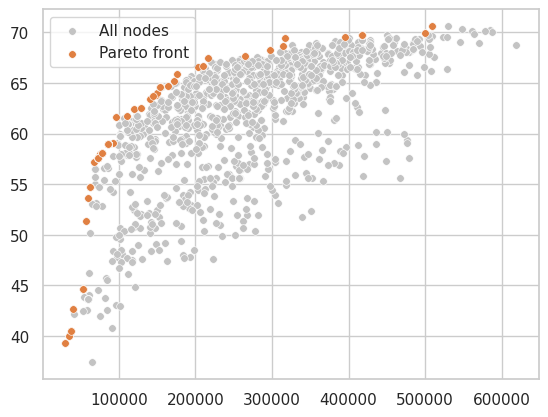

In [119]:
u = (np.array([[u.get_reward(mc.api, mc.df), 
                u.get_metric("n_params", mc.api, mc.df)] for u in mc.visited_nodes]))
pareto = (np.array([[u.get_reward(mc.api, mc.df),
                     u.get_metric("n_params", mc.api, mc.df)] for u in mc.pareto_front]))
sns.scatterplot(y=u[:, 0], x=u[:, 1], label="All nodes", s=30, c="#c3c3c3")
sns.scatterplot(y=pareto[:, 0], x=pareto[:, 1], label="Pareto front", s=30, color=sns.color_palette()[1])

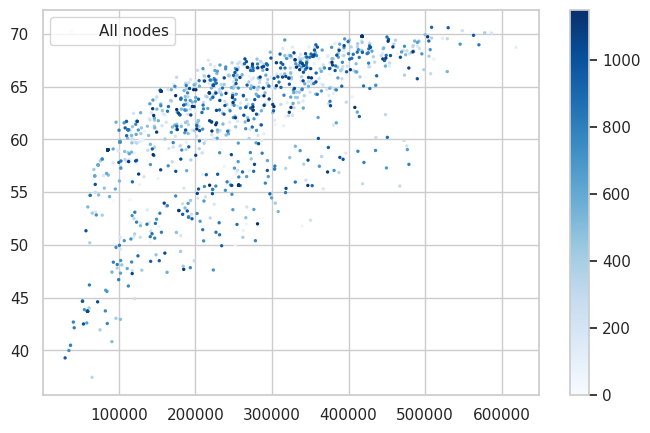

In [120]:
f, ax = plt.subplots(1,1, figsize=(8,5))
sc = plt.scatter(y=u[:, 0], x=u[:, 1], label="All nodes", s=2, c=range(u.shape[0]), cmap="Blues")
plt.legend()
plt.colorbar(sc)